**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Cross-validation

**1.** O código abaixo carrega o banco de dados *California housing*. Divida o banco de dados em treino, teste e validação. Use o conjunto de validação para escolher o coeficiente de regularização $c$ para um modelo de regressão linear com penalização $L_2$. Use a fórmula analítica para estimar os pesos do modelo de regressão. Plote os MSE no conjunto de trieno e validação em função de $c$. Comente o resultado. Avalie a performance do modelo ótimo no conjunto de teste e também comente.

In [54]:
import numpy as np
from sklearn.datasets import fetch_california_housing

SEED = 44
np.random.seed(SEED)

X, y = fetch_california_housing(return_X_y=True)

In [55]:
# Seu código aqui
from sklearn.model_selection import train_test_split

X_with_bias = np.hstack((np.ones((X.shape[0], 1)), X))

X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size = 0.15, random_state = SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size = 3/17, random_state = SEED)

In [60]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

mses_train = {}
mses_val = {}

XtX = X_train.T @ X_train
Xty = X_train.T @ y_train
I = np.eye(XtX.shape[0])

c = 0

beta = np.linalg.solve(XtX + c*I, Xty)
y_pred_train = X_train @ beta
current_mse_train = mse(y_train, y_pred_train)
y_pred_val = X_val @ beta
current_mse_val = mse(y_val, y_pred_val)

mses_train[c] = current_mse_train
mses_val[c] = current_mse_val

for i in range(11):
    c = 2**i
    beta = np.linalg.solve(XtX + c*I, Xty)
    y_pred_train = X_train @ beta
    current_mse_train = mse(y_train, y_pred_train)
    y_pred_val = X_val @ beta
    current_mse_val = mse(y_val, y_pred_val)

    mses_train[c] = current_mse_train
    mses_val[c] = current_mse_val

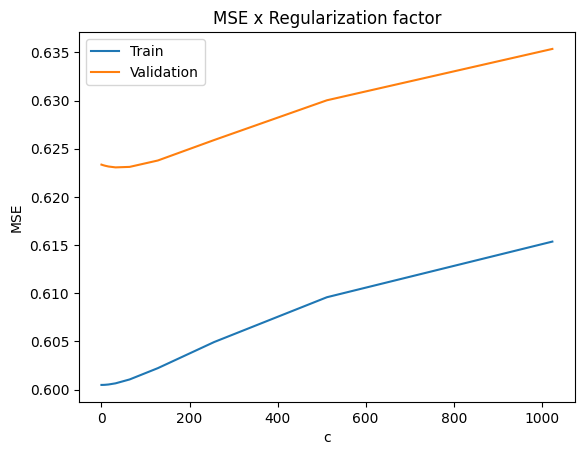

In [61]:
import matplotlib.pyplot as plt

plt.plot(mses_train.keys(), mses_train.values(), label = "Train")
plt.plot(mses_val.keys(), mses_val.values(), label = "Validation")
plt.title("MSE x Regularization factor")
plt.xlabel("c")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [62]:
best_c = min(mses_val.items(), key = lambda item: item[1])[0]
print("Melhor valor de c:", best_c)

Melhor valor de c: 32


In [63]:
XtX = X_train_and_val.T @ X_train_and_val
I = np.eye(XtX.shape[0])
Xty = X_train_and_val.T @ y_train_and_val

final_beta = np.linalg.solve(XtX + best_c * I, Xty)
y_pred_test = X_test @ final_beta
mse_test = mse(y_test, y_pred_test)

print("MSE no conjunto de teste:", mse_test)

MSE no conjunto de teste: 0.6079416453456845


**2.** Implemente 5-fold *nested cross-validation* para escolher entre os métodos $k$-NN e regressão linear com regularização $L_2$ (similar ao exercício acima). Considere $k \in \{1, 2, 3, 4, 5\}$ e $c \in \{0, 1, 10, 100\}$. Use o mesmo banco de dados do último exercício e comente o resultado. Em média, qual valor de hiperparametro resulta na melhor performance para o método escolhido (use 5-fold cross validation regular para isso)?

Obs.: para simplificar sua vida, use o $k$-NN para regressão do scikit-learning com distância euclidiana.

Obs. 2: para mais informações sobre o $K$-fold *nested cross-validation*, recomendamos esses materiais:
- [Algoritmo e breve explicação](https://weina.me/nested-cross-validation): a autora apresenta uma boa explicação do assunto acompanhada de uma descrição do algoritmo;
- [Ilustrações e explicação acompanhada de código](https://ploomber.io/blog/nested-cv/): ajuda a visualizar melhor o que é *nested cross-validation*; vale lembrar que seu código, diferente do dos exemplos desse link, não deve utilizar scikit-learn para implementar a *cross-validation*. 

In [64]:
# Seu código aqui
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Função para separar o conjunto de dados
def split(array, slice_index, total_slices):
    parts = np.array_split(array, total_slices)
    slice = parts[slice_index]
    rest = [parts[i] for i in range(total_slices) if i != slice_index]
    rest = np.concatenate(rest)

    return rest, slice

# Embaralhando os dados
data = np.hstack((X, y.reshape(-1, 1)))
np.random.shuffle(data)

X_shuffled = data[:, :-1]
y_shuffled = data[:, -1]

# Listas com os erros em cada conjunto de teste
errors_test_knn = []
errors_test_lr = []

scaler = StandardScaler()

# Para cada grupo externo...
for i in range(5):
    # Define os conjuntos de treino + validação e teste
    X_train_and_val, X_test = split(X_shuffled, i, 5)
    y_train_and_val, y_test = split(y_shuffled, i, 5)

    # Dicionários para armazenar os erros em cada conjunto de validação de cada hiperparâmetro
    errors_val_knn = {1: [], 2: [], 3: [], 4: [], 5: []}
    errors_val_lr = {0: [], 1: [], 10: [], 100: []}

    # Para cada grupo interno...
    for j in range(5):
        # Define os conjuntos de treino e validação
        X_train, X_val = split(X_train_and_val, j, 5)
        y_train, y_val = split(y_train_and_val, j, 5)

        # Para cada valor do hiperparâmetro k...
        for k in range(1, 6):
            # Treina o k-NN no conjunto de treino e avalia no de validação
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            knn_regressor = KNeighborsRegressor(n_neighbors = k)
            knn_regressor.fit(X_train_scaled, y_train)
            y_pred_val = knn_regressor.predict(X_val_scaled)
            current_mse = mse(y_val, y_pred_val)
            # Salva na lista correspondente
            errors_val_knn[k].append(current_mse)

        # Para cada valor do hiperparâmetro c...
        for c in [0, 1, 10, 100]:
            # Treina a regressão linear no conjunto de treino e avalia no de validação
            beta = np.linalg.solve(X_train.T @ X_train + c * np.eye(X_train.shape[1]),
                                   X_train.T @ y_train)
            y_pred_val = X_val @ beta
            current_mse = mse(y_val, y_pred_val)
            # Salva na lista correspondente
            errors_val_lr[c].append(current_mse)

    # Calcula o erro médio nos conjuntos de validação para cada valor de hiperparâmetro
    averages_val_knn = {i: np.mean(j) for i, j in errors_val_knn.items()}
    averages_val_lr = {i: np.mean(j) for i, j in errors_val_lr.items()}
    
    # Pega os valores de hiperparâmetros com menor erro médio no conjunto de validação
    best_k = min(averages_val_knn.items(), key = lambda item: item[1])[0]
    best_c = min(averages_val_lr.items(), key = lambda item: item[1])[0]

    # Treina o k-NN no conjunto de treino + validação com esse melhor parâmetro
    X_train_and_val_scaled = scaler.fit_transform(X_train_and_val)
    X_test_scaled = scaler.transform(X_test)
    knn_regressor = KNeighborsRegressor(n_neighbors = best_k)
    knn_regressor.fit(X_train_and_val_scaled, y_train_and_val)
    # Avalia no conjunto de teste
    y_pred_test = knn_regressor.predict(X_test_scaled)
    current_mse = mse(y_test, y_pred_test)
    # Salva na lista
    errors_test_knn.append((best_k, current_mse))

    # Treina a regressão no conjunto de treino + validação com esse melhor parâmetro
    beta = np.linalg.solve(X_train_and_val.T @ X_train_and_val + best_c * np.eye(X_train_and_val.shape[1]),
                           X_train_and_val.T @ y_train_and_val)
    # Avalia no conjunto de teste
    y_pred_test = X_test @ beta
    current_mse = mse(y_test, y_pred_test)
    # Salva na lista
    errors_test_lr.append((best_c, current_mse))

# Calcula o erro médio nos conjuntos de teste
average_test_knn = np.mean([i[1] for i in errors_test_knn])
average_test_lr = np.mean([i[1] for i in errors_test_lr])

print("Erro médio do k-NN:            ", average_test_knn)
print("Erro médio da regressão linear:", average_test_lr, "\n")

# Seleciona o melhor modelo
if average_test_knn < average_test_lr:
    best_model = "k-NN"
    errors_test_best_model = errors_test_knn
    best_hyperparam = "k"
else:
    best_model = "Regressão linear"
    errors_test_best_model = errors_test_lr
    best_hyperparam = "c"

# Seleciona o melhor valor de hiperparâmetro como a moda dos selecionados no processo
best_hyperparam_value = np.argmax(np.bincount([i[0] for i in errors_test_best_model]))

print("Melhor modelo:          ", best_model)
print(f"Melhor hiperparâmetro {best_hyperparam}:", best_hyperparam_value)

Erro médio do k-NN:             0.41201272832403096
Erro médio da regressão linear: 0.6149827524373794 

Melhor modelo:           k-NN
Melhor hiperparâmetro k: 5


**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Redes Neurais

**1.** O código abaixo baixa e carrega o banco de dados _CIFAR10_, que contém diversas imagens RGB de **10 classes distintas**. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação.

Também provemos um exemplo de como definir um modelo em _PyTorch_ (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. **Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação.** 

Eu espero uma busca de hiper-parâmetros razoável (e.g., definindo um grid de hiper-parâmetros). Eu sugiro utilizar early stopping e algum scheduler de learning rate (e.g., ReduceLROnPlateau). Como de costume em deep learning --- devido ao tamanho dos bancos ser razoável ---, não de faça coisas como cross-validation.

Consulte a documentação do _PyTorch_ para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado.

Além disso, mostre como os dados de entrada são transformados ao longo das camadas do modelo ótimo (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente. 

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm


cpu


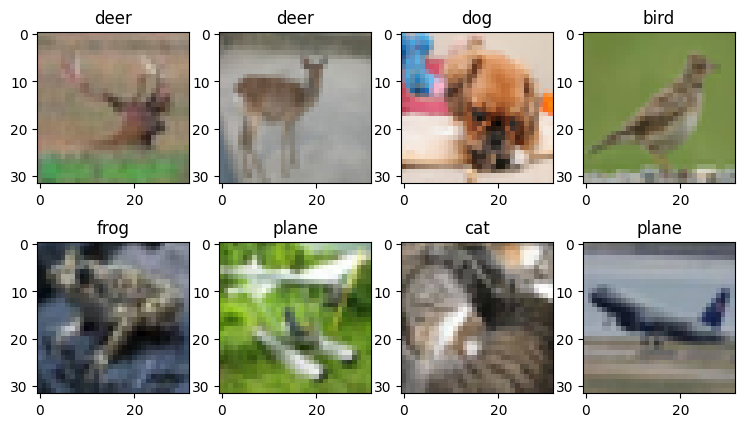

In [66]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# The batch size
batch_size = 2048

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transform_train,
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transform_test
)

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

n_img = 8

f, ax = plt.subplots(2, 4, figsize=(9,5))
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(n_img):
    npimg = images[i]/2 + 0.5
    npimg = npimg.numpy()
    ax[i%2,i//2].imshow(np.transpose(npimg, (1, 2, 0)))
    ax[i%2,i//2].set_title(classes[labels[i]])



In [ ]:
from torch.utils.data import Subset
import json

train_indices, val_indices = train_test_split(range(len(train_set)), test_size = 0.2)

X_train = Subset(train_set, train_indices)
X_val = Subset(train_set, val_indices)

train_loader = DataLoader(X_train, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = DataLoader(X_val, batch_size = batch_size, shuffle = True, num_workers = 2)

class CNN(nn.Module):
    def __init__(self, n_convs, n_neur_linear):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.LazyLinear(n_neur_linear[0])
        self.fc2 = nn.Linear(n_neur_linear[0], n_neur_linear[1])
        self.fc3 = nn.Linear(n_neur_linear[1], 10)
        self.n_convs = n_convs

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        if self.n_convs > 1:
            x = self.pool(F.relu(self.conv2(x)))
            if self.n_convs > 2:
                x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
criterion = nn.CrossEntropyLoss()
num_epochs = 1
patience_early_stopping = 10
delta = 0.001

lrs = [0.01, 0.001, 0.0001]
ns_convs = [3]
ns_neur_linear = [(240, 168), (120, 84), (60, 42)]

best_lr = None
best_n_convs = None
best_n_neur_linear = None
best_error_val = np.infty

errors_lr = {}
for lr in lrs:
    print(f"Iniciando com lr {lr}")
    errors_n_conv = {}
    for n_convs in ns_convs:
        print(f"- Iniciando com {n_convs} camadas de convolução")
        errors_n_neur_linear = {}
        for n_neur_linear in ns_neur_linear:
            print(f"-- Iniciando com {n_neur_linear} neurônios")

            cnn = CNN(n_convs, n_neur_linear).to(device)

            optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=lr)

            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn,
                                                                   mode = "min",
                                                                   factor = 0.9,
                                                                   patience = 5)
            
            best_val_score = None
            counter_early_stopping = 0

            for epoch in range(num_epochs):  # loop over the dataset multiple times
                cnn.train()
                running_loss = 0.0

                for i, data in enumerate(train_loader):
                    inputs, labels = data[0].to(device), data[1].to(device)
                    optimizer_cnn.zero_grad()
                    outputs = cnn(inputs)
                    error = criterion(outputs, labels)
                    error.backward()
                    optimizer_cnn.step()
                    running_loss += error.item()

                average_train_error = running_loss / len(train_loader)

                cnn.eval()
                error_val = 0

                with torch.no_grad():
                    for data in val_loader:
                        inputs, labels = data[0].to(device), data[1].to(device)
                        outputs = cnn(inputs)
                        error = criterion(outputs, labels)
                        error_val += error.item()

                average_val_error = error_val / len(val_loader)

                print(f"--- Época [{epoch+1}/{num_epochs}], "
                    f"Erro no treino: {average_train_error:.4f}, "
                    f"Erro na validação: {average_val_error:.4f}")
                
                scheduler.step(average_val_error)

                score = -average_val_error

                if best_val_score is None:
                    best_val_score = score
                elif score < best_val_score + delta:
                    counter_early_stopping += 1
                    if counter_early_stopping >= patience_early_stopping:
                        break
                else:
                    best_val_score = score
                    counter_early_stopping = 0

            if -best_val_score < best_error_val:
                best_error_val = -best_val_score
                best_lr = lr
                best_n_convs = n_convs
                best_n_neur_linear = n_neur_linear

            errors_n_neur_linear[n_neur_linear[0]] = -best_val_score
            print(f"-- Finalizado com {n_neur_linear} neurônios")

        errors_n_conv[n_convs] = errors_n_neur_linear
        print(f"- Finalizado com {n_convs} camadas de convolução")

    errors_lr[lr] = errors_n_conv
    print(f"Finalizado com lr {lr}")

    with open("errors.json", "w", encoding = "utf-8") as f:
        json.dump(errors_lr, f, ensure_ascii = False, indent = 4)

Iniciando com lr 0.01
- Iniciando com 3 camadas de convolução
-- Iniciando com (240, 168) neurônios
--- Época [1/1], ---- Erro no treino: 2.1089, ---- Erro na validação: 1.9340
-- Finalizado com (240, 168) neurônios
-- Iniciando com (120, 84) neurônios
--- Época [1/1], ---- Erro no treino: 2.1510, ---- Erro na validação: 1.9819
-- Finalizado com (120, 84) neurônios
-- Iniciando com (60, 42) neurônios
--- Época [1/1], ---- Erro no treino: 2.0966, ---- Erro na validação: 1.9120
-- Finalizado com (60, 42) neurônios
- Finalizado com 3 camadas de convolução
Finalizado com lr 0.01
Iniciando com lr 0.001
- Iniciando com 3 camadas de convolução
-- Iniciando com (240, 168) neurônios


KeyboardInterrupt: 

# Gaussian Processes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns
import io
import base64

**1.** Durante a aula, discutimos como construir uma priori GP e o formato da posteriori preditiva para problemas de regressão com verossimilhança Gaussiana (com média definida pelo GP). O código abaixo cria um GP com kernel exponencial quadrático, mostra a priori preditiva e a posteriori preditiva. Experimente com o código e comente a influência de ambos os parâmetros do kernel exponencial quadrático, tanto na priori preditiva quanto na posteriori preditiva. Nos gráficos gerados, os pontos vermelhos são observações, as curvas sólidas azuis são a médias das preditivas e o sombreado denota +- um desvio padrão.

Text(0.5, 1.0, 'GP posterior')

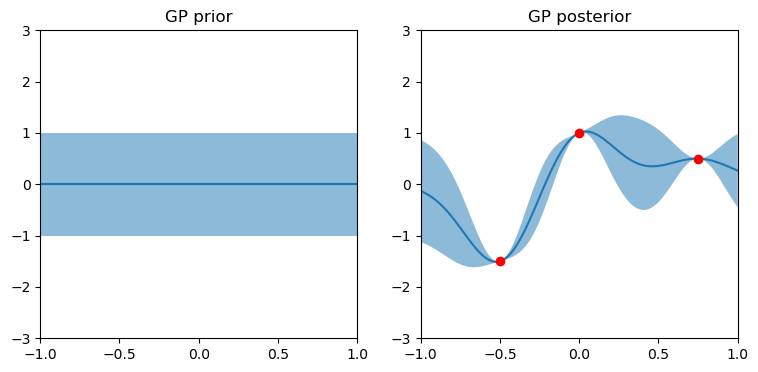

In [ ]:
SEED = 42
np.random.seed(SEED)

s2 = 1e-04 # variância observacional

def rbf_kernel(x1, x2, gamma=10.0, c=1.0):
    assert(gamma>0)
    assert(c>0)
    return (-gamma*(torch.cdist(x1, x2)**2)).exp()*c

x = torch.linspace(-1, 1, 100)[:, None]

K = rbf_kernel(x, x) + torch.eye(x.shape[0])*s2
mu = torch.zeros_like(x)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].plot(x, mu)
axs[0].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-3, 3])
axs[0].set_title('GP prior')


xtrain = torch.tensor([-0.5, 0.0, 0.75])[:, None]
ytrain = torch.tensor([-1.5, 1.0, 0.5])[:, None]

def posterior_pred(x, xt, yt, gamma=10.0, c=1.0):
    Kxxt = rbf_kernel(x, xt, gamma, c)
    Kxt = rbf_kernel(xt, xt, gamma, c) + torch.eye(xt.shape[0])*s2
    Kinv = torch.linalg.inv(Kxt)
    Kxx = rbf_kernel(x, x, gamma, c)

    mu = Kxxt @ Kinv @ yt
    cov = Kxx - Kxxt @ Kinv @ Kxxt.T
    return mu, cov

post_mu, post_cov = posterior_pred(x, xtrain, ytrain)
axs[1].plot(x, post_mu)
axs[1].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
axs[1].scatter(xtrain, ytrain, color='red', zorder=5)

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-3, 3])
axs[1].set_title('GP posterior')


**2.** Durante a aula, discutimos como escolher os hiper-parametros do nosso GP. Estime os parâmetros ótimos para os dados carregados abaixo (acredite, é isso que o código faz). Reporte a evidência obtida e faça um plot similar ao acima. Para o dado de teste, reporte a i) log verossimilhança e ii) o MSE com relação à média. Em caso de dúvidas, recorra a nota de aula e o link adicionado no eclass.

In [ ]:
data = np.load(io.BytesIO(base64.b85decode(
    'P)h>@6aWAK2mk;8Apo$)IktlX005u^000XB6aaK`VQFq(ST1gGc>w?r0H6Z^000000D}Vn000000G-JFQ_}?;!0~YzY=9g==Y&XhJ79<?P+Lz&d|0HoP>&SM'
    '2NI?X(A<!XAf&F9gxYZsB1plJNq0ihIRZpQ_$**23=qcCzMEScGRBv|9&{@)AhLg<_iyi4)xOld$%ox21(ae|ra*E+%zB5xip_e970F;_<%;vgd{KI?I8*SS'
    '@8X}92%ftnhkr)!{KI3SqaztHTO%1?F#czrlL<L1=1>jXSP9_`ra#1EFBN&dUp#}93U`}z=Uq7W<3m;jT?g?mc%DzX*@x|yc(1GbZBQcI^|rK04V2BBL^Y+2'
    '2>OV&sD>fT|N5`c9=}Oc-;Ux)Kh#5%KK0C}5=2f&UT^G<B|Itrr%Vx`M7!#hh-(FZfcVH+w$FYOzHvTfU7#>wvZ_WXWywJL>hZevBpDQT^trs*DhO5Dx6wZ~'
    '!v-$V<-Dtd`E%k=Xs3rE#nf`py+{YH_eyu}Zl1;=a)XkTsql7Za04@Q26fwFD3`OfxLm?bo9G(@bL+s2Gth#yia`8xS&mna<{tU`x8IS%3~Ifuzle^nF1$Oq'
    '+KbUaeQpyT1dh$Edi<>I#kEak-MsA!kV)ShvPHNAZV}_Rs^}u9td17*yGFs8ad~gY_ar)B^!hCNgc^wsrl)g6fk9cRPwVpLp>u+}<>ki)l;5d}FHHXl{WZG7'
    'C;jap_g;LHbT)#a(VMt#9tJ9t)!vXuq6qn={f|sQnfIcF9an-Xxcex}zY}Csq9U0wi6sGLmP$Vj62*^s)Hnt9+sTc3wi*r;gfKt%AR%64&EI#Z8d7FHaQU@N'
    'frB|1=vY_4L7yh-ug^wd53_iglQs<lTeG<iat;hn&RT6P7JRVASl@0mg7!vvm?GPVu0}7Nrg9cDLWkVHE$fAnxT!kAuz*F65;ZZ+B$)Esds=y8P*zU@S*wFK'
    'w<vb^QyY$cXQ9a=2f&wBV0_}&4N|+@`oqK=);7=Hp|j1XuDMqk<e`D^gt6@A*VOpYsq*sTO9Z4Fo^1>!x}a9VXWtVJ<Lb(^`50#rcGzT7i~2cO`tsJoQ2aQa'
    'N(u`b=2&rY#1fFUM&Q*1;RC6!5@Yw1yXmo7=qaT7y4vhOHYq#!dE*%FTX3j)#0ZX}3~rwGKGbt4aW^j#Fnz!28|wixCgxm8jGG<AU+R5ARn<n6GToWiXp{Ia'
    'P)h>@6aWAK2mk;8Apk!*Q7DH4005u^000XB6aaK`VQFq(c`j~nc>w?r0H6Z^000000EYtr000000G*KSGaCjRfKy`8t*7DEnx=P)x;5ltqPkwS_{k~h(iOYe'
    'O?L<t%BCWTWlE8&iF)a%+|5NB+ODeRWn$XRgdeh1hY^vq1VIv~=?xX@wI;3Ezp&@q^L%_{k)NK9KC^=$Cgjn0DWYT{?HH97lzNoLpwd$L!fatuCYLYdrTo_;'
    'k}^ao+g+5Fl$EmW-u_G`gX-_YpypHmCvWQRlTzoBC(vOzFCY7KAgjDN%<$4duk3PdbIm0DDZgC&UhWh|#(pJ`*DgZi?~DzubqGv7CqC?ppGEf5&gcODRk&;S'
    '&hcASfrB($S$FR@kY=?lb<(Gib8=If@uL-N#|GT}&W>R30q<aG>0{`8IsfaOu5M&p-|t>h-hh_+8izM_D3Rsc_<o7_Dct(U@d$C!3=QvkbQpRTP*GjTUhg)d'
    'GN9TR5<P>VBG&+cUW?hxvb3mHBNCk}<wU1Z@Y)r6?}N5sP(6F>sn|OTt97sDDBr1pNp>0ITsLF<iDvt`*d9pJz8yH&Z-mG%-MjouW=M>Rjk#a<3?38&>eoZf'
    '&{rmIjyOC4H&!gSPBEW=x>BadcI?4#oQHRb_!=0WmIPe2tpQ>3cHzDwb9l<-w4-mrAX?+aI~%#(5O<|y;$+(+NTkSFyD#eS!kM~1#t3?7sN%mRuD3y4aCoux'
    '!8q88>=k7BUl9H67Y=0-4aWMYifd-Cg70`CAwAcC50l9;1I`9a=(4diTV{w;hBh51Yhc3eIlD)qg{lq<otU}+L0rw}WgcdXu?pzZ6g3h{1LFk-8&uF~KWK9;'
    '7+##?dMTqFcmHBoT$auw@4{zb;h1oxmb@O}G>841YXz;dW9Y_OQJi}*gX%it0Qt5SoL+x2*<|m4wUDAs*C#(img;=r7PSeYu7o*DLe$uj_xy&}-~uj@vWxVj'
    'X)G^x&s^R}MAP?#!2`AZxUc-+T$SAjlDi8(c{&awpWPX@*G&f1A*5@R7iNq&xUpH?G6Y-eKBS821<Y?%vKP0%S$B%3Y-__1e4JF@a<~REU%Dt*?Rwnb;9a@&'
    'wHnxLtM(DOAO6lwpHeclu;-FFotH2Ql$kZZv%GoC2`jxrXx2bq`#a}@p7#Qm^6{vaGlWM4>+XkiP57GV!8t@XVOEeqSdj7%=i4Q2d8tkCk*RUy)yNQByr~*V'
    'RM*14P)h>@6aWAK2mk;8Apn6>1aKG%001Bm000UA6aaK(b97%=E^csn0RRvHAP@im000007zzLY00000omcx~j%6R8w`g=49gOr^hM}ny%_{j!$)TvxfsiKK'
    'sKiWZBW<J_t;k_fVx=^dEEYD)XUy5mFx$-O+4<SCqeGF%dtdkG{tMpchwVAs_jO;__xt^vmOS^;u&`H}dCl;e6%Y|QeL_sYV}1dBqe21#{Q{z<#=H|Ve#&c8'
    'V<IBW_XEdIo*rp^KYh~p=t%2xw?~440{tH99_TmQ@Be(Y^0Hq|EV*^>(jI3UnSRgb-Cx??$c5J5_-`6Hu}_B=etN%={huzcE*R5D^Xd9yjr=QoTI(L|8<{sH'
    'WbKQ8H*lTxZG3S9KU}cq@VYGxe0BL}5e3N&G{64)ZUgVI7j9tvj<QZK_HN)_>#7g#XyBUD(L>jrujkC#KBdQw)YDx3Z(2QrZranT`=WZbyz8^oFHEgxsdd)}'
    '&($+4=$`$lJ?oj=uk6)hx75?zeXX{R&yJ4%q}#zdc9~>0Tt~CY?D=&p`Ed8ssgvrs@r$IAql4;bR=d`<juY3nzp-13I`-dIx_m@sE!$hG&fZnai-l8n{<x-='
    'hbw|d9-UiDv-;KXwVda*J0YNdEyvxKbk_*KT87w#@UTsf_W1FPhxKOre|Tt~c6FtPDdsWndpL7^@Z#ZPJbcl7e9S}ZA=}or^YErmKMgx_xrXNH{}k0QYi+xk'
    'UANRQIo);J@Z=gsTf3O`ZViXzn*!Ic%b7<G<@c(g+08#~YFPYt&R<>5ySdR`$W61WS!r%Y`nUW2hlOt9A(wTln`U=chPioh=#=SQdb*i6`VsH2Tije{?Q&*q'
    'HRsI8dFY1&)f_v|G_IOvw^tIY>67By)Ok`hJ?qcTdwx(gcW*NrtmdlyZ~yvz^J>Nx^?vGbMHOGLcK>%y6?<OTIl1$iD&Ev=L9^%QR<YDNMcnu*ZtLKC|M#I)'
    'w1$g$9jiFi9*9Z~8TfXM|Cvhqo3{Q@$!pfB;#O9&$drFpC4ZYezi-~?N+y{yJzB}A6>X#Z+f_2u9OrTc%_(DxDtOU6c5?;u@_S_*T2?{(=XWYNx6TY&1;<`V'
    'd~aB<3I<!Jj%`yxpS#<B``x*6di+g6%V|!3X+t?zVe)I87M3%1STCzo<s31_+*r=QH+J0nU0^v|yqCB!_vUiCtZH2HlreMh-KXw5P{ySxW`N5$#j47CiDev|'
    '_10J4PAp@m0}nr#JFtvbi%g@+SXh}o>b~Y>OuO(&{j(LNG*z0BQ_6_j&4x<Z@7~itADmN4Q?0+kOL;!zt>b>7rOX}p@SD$eETs*je_c#?J$p&YX&3Er&vMaJ'
    '@6WGYw8wImi#01wRXsD>#T+v}kGlBH?{8YIbg|*%3C}ERJj*rTottj;lrLN8#^keXCE(Lqq^ZVzhB2+}fo7MUTc27Qd4?r}?MCr)3(ft?PP4x@K>PA>r}>kG'
    'Vr%cT!1%<Hlc(6G@vA8Jic>V`ePYxp#&zA2VU>zOPZ|O_$#PxD<#7fWCpmOk<7?HopJX$;;U!GZy?K)bRZeo7gOu<d3#ENqmN38L<_EvndxG;GAMi@mM<*C!'
    'q4V(pCs-E~{>!5OoZ#xu8;)0I7t^Mv_+on78z|;B0gTZGewjt=tiho@zQILIGUN4UAwy03Hx=@tY0tDmrke5v6>=<Fnx*M;^2>eYzZ~Z-3w2g&IJ1o*wBzjg'
    'fPFBQ*+4B|a^yI}e0*k(8NdQwTWK>JH*WQ|nCuv%3T)<LdkbBCIviu3ecYp*8(^5|D1)D}nTMWnuUaiV%2gspjz~5IJHi$MJTnh1vzX!tr_|Vk%udbC5BV(g'
    '3pL2+g1!dn`FuakJoqpTd$Z+X4()jE*Ec@SWBSXt{^!mc^4QVPef%LN+QgO1Mnf-gxg2Q^)<I^QagI62ZfiDQY~6T(Usx=f_0|DiZfzR9pW#DpZt#iR&;1GJ'
    '0Q(qZ#%A0;F1OpdmtFx@*+=f>M7u0|m~XZ{d=Eno8Nlx5>Kp5=$=pqEtI4<S-NoqXX7YBi_$M=IISe&4|3nT`4LxS;q>rJM;GK*$aNM+mE{jz*Ke&T~FL|s<'
    '$Y%NjMmVw=VgrZtemuT-`+)5%GIG=J52hMg>yyP;1D~L69ApbwCfi0Dg2|xUV)4ulTe;=QRu(k3F!49@W-~`x?7G$acXnU6$*NpBFWE%Ak^2n&T>Op8PmZ-J'
    'k;Z(R=r%Aq=Ii_4*s-2IhIZ0_<_4Si*D=hLYsHUjbejhMz(qzbKUl*c1N&*;GUbK|AKkfc70+%T@ZX8+zhbC4_Tps58`_Rt%y=U+nMu4p@=NQ=dAz>T06do0'
    '?})SBh108z{U2WX9tpY*Ub+vVS_fWQ7uk9a67*d7X&*??zTnb65vqM-wa$TNIv2uqPGsxcSfn~2TXjK`>I6U44bQ8NNKjporaGfkb%&4ofKc@X(drXY)HfVf'
    'AJI&GMUeW84eC2WH3ultTp(I=0&mR?R%?zBqPar8<_wcGckt32V!7rLL7G$S)7&ClbBxPf?YYK6%{jVh?vX7VV3cryCgB8$!VUa{BV-6y2ouiW7Va=dIE1fo'
    'i8SF9Lxfwngk!`C*GLr3Q6Su-qj&&six;p}Jb@d;8weARK(urO)#4fS7VjWIJcNVdCHRV`5Fy?|ns^LXwEzZ-=de_~2bXvdf#OBPiYJjR-o!29QH&C=;(PHd'
    'n#8;4D;`Focp1mU)9@2-W3qT08RB&`7tbS1ypOM?18_?h&|5lzInoW}N=M);UBLwD4AP`KxSD3`5C%z?uv9t)mvjsFOUDo^UBfQv9B!BHVXSlzsnSJUkWM00'
    'x``y|D2k=4=q#PZH0ds~q{Hx*F5@NXG*YD7sFRLkrF0!TrSou0_u=>eIKBXmPk`ea;P?nQz5-418Ms@%1AXN~@Va~n=F6wxSNRqc$j9J{d=32Mb1+c82b1N4'
    'uvoqbTji5*M!pF*%15Dxd=<jvvoJ%x3oGTruv5MaZuvCaCf|nM@^Kg~Uxx(wJgk-PL#})v&dV3VS3VK_<QowoABhF>l}MA%M4@~quF8j^lYA-Erb<kaZ-wJy'
    'kttsbmwYZ-$oC>pJ{ZI0i{bcWIKCN<kA~x`;rMJgz8j7YhvUn!Rz4lM^6fY$ACI>3^>BPXBINrqUpWA2$^|&CoPd9n8{n@Tfx*fZn4+A4CCVMhP!54hxdcv5'
    'L7;LAhAYP)PPqo(DCc08at}PpLGV#7La=fY#wa&oj&c-Im8+1aoCPO$p`CIVpj-wgry)tX4Ni_jv2q=poCkm9J~%lLPA<eU<wQ8S5l)Uo3*|~YpqvROcOp(X'
    '6swg>;p9}*D!0PPu?SYKg_CnJSGgB!m4o5rVq8#8hOcrnoE(iP<!U4;XT!<eC{_-KlgsfxP)h>@6aWAK2mk;8ApnKqayn=a001Bm000UA6aaK(b97&ME^csn'
    '0RRvHAP@im00000Xb%7Y00000otODL6pYu#QzY9%;*q6HlD$%t@|06(AuY6^WF1>b3ME7#Yg!SNL|L+veK{CoUuK3emccN#EZJIA)Ytnjyyv&`xvq1a`#Se8'
    '_j!Ki;^}jy9BVw+c*_%QZ`s_G*CfavvO6HJLXfv}z3G0_>biyNO``4p@#9v`w`^DWEeER`wyV9uK2=o}!X8Bxf-m9!S-b}K>b6+MXW;Yee5~_^&tXkkhOa<|'
    '1!i+3Yw&nQBV`;e6~vf=L)=m<2Rj~9&#YkvoUntn23KZI#M80=gCl4pe!wf}DYn@@4sS$qq>|!N(JAL25j~DX3>bcRgQS@W5iVsJE6#c7ADL31>(>P9i#}UO'
    '31)(yfi%JTPY5n_r9Y>+B%r3iJCEY*7Z@8V&$w$+ieJAG_>vT(QEM_i_i9HZXzkiAwJ9eVv@3jH1|3a?HkpZ;ryU>gs@Jo!_42hS#xUdhoKS%KKU=>I;;#Y6'
    'YrzU4wz+WS^6Qrzv~bwA!9#Z2ND1~fTK-I4euY(EsRxt$Nf^i})^pak5U<dSRJf^Gn6~qF<01KcoRc{JNA7SsaB(qnG=}Su`#7JIz{zS1Q|(yz^Irq@D9NPF'
    'ey>B^^d~p;Rw_R3ZD-rYv>=7hS}^M910sHA;_vE;G5*F#XJSh(-tLoFE}*0$_2?7jR_iKUN<iNtg$T&;>-XlQmE)$@d&He%lhB2=?^@_a#0z2fFaG;B9}i4L'
    'tTCPbgmPc1P%ym^2|<5VBpsVEeXdqvqBS3b4&O=S`bNS7_MV@1N93UJ+sPSy!7h{tzw}@ylZrAy(-S>@C3xtZ_nv00RH(Ca|DmmtiBg@(@6>vlaQeq4-UACA'
    '$d{z^kj|Nhm7Moyhhj+hftAx3yR#6FXKa5|x1$<2$NM~7RINenD1-L}2T2elr`E1uSA)xAdfa(CYVnD8X%IS)a5`jb`KjdwoXF7?v_77Qt@ZZ)!@6YTUoXoU'
    'WtM|`#Vv~)w2F}+IPxif#2!Qgg=dq_<zYkMo!=F@tr&IRU@K{{6^Yi{8l9=h5ISGl>#~i6qGAU<OHMXpuIHDeLarKg&S_*wMrJ`etuWx&{YG5!xV~wtaWy)}'
    'KH`_tD?<Zwd#B+M5}xO5zbw#RjjeYc?aFVe#pP^6-pGGb(MQEr<3f5Ijz?*BSw^KIIUw}!{I+U*{p1iU<{TMn8uZ_U8GXWZX6(+0fFfWSSG*%hBp|>3KRX-V'
    'lc39hkdRJpfDO8GN8-6+z&WPz$imNDywEOD-Na}FOEvbl(~5MM^Rm7~lxqaGf};ufY(1#Ftv6bZpg?!*?%)T*6rfi5P#t3`U~8_8zL8E1h~maMzdkBh`KFqw'
    '8#TkdaHlhrNCy0YqoKz4>%jSsP2G1PIyjY2$ha)i;2zI~2u)uKD7PQbc@I6H;N~UM7SsiDp(z^<ST%s^Be!c;cp2b+KJV4UKTL2w{hn$}rh)nt(fGU`4JIY%'
    'e}yyK!N+WJ^A3$ps3hrh&d|GoU=^})JE;wR>2`>}Rd0a6L_ekJOEj?Ee6Wanx*iU5aa=AI>V^h3duzovDy-Ad2^FE#K<J`*Vw)BXDk9@fY!U4MjotCKdcV71'
    't}5=H=1&^TYG;nTe>4crk+vo0g(&dY)s&H%MuW&2+fZI%8Z-wc9hP`Xf!Y0}z}F)*$OuSCo#CcKhK*xQOI{C@2B+tf#!8`C%D!Z5Lle0BXGjT;H9}a5W=Em{'
    '9hmHO0k$%Y!0KI@E7+R|$)Wza+d5jHYhH26TCWM7OLL0kakfCfIdLK8N+F165BlUYy5MZ_{HO4O8ek?GA2ALf!6YM?%^{HwYzM)64`OoQtYAyPvQRvz*%{8i'
    '6fXk>?IJtr&}5kVdc5pq799rLYIX(iXJNy$U)%-1L%}JqN6EDP6I9$>*>^U#9yXnJ>rdd!hl9Q9cdKRVA!i8^m2)G2r`L1iQL#$+Xh8PArbB~T+L7kyoF_1^'
    'OsNT8B7u(1j&IV>szFp%H<y@Iij_Ldu?@vJP`7>ffZkXewAXDMtemTXlZ3hfi>VjjB`V;cOlbzDYyb1Tb7e4S(VOBxZ-j{Qn@!9M%|Jc4QSJDpd}vQ4rkPYy'
    ';lCpRiK)bLxYM7q)#P9?s9SOcD;tsEF(HIDD$)Y(@2{J2f2D$($6FP<#wNI?9NBwSsT<m3U86Nrx`6E{FGRdVg*Jowp&e;V$bDUHe*fbj7yx~KV4)l02<zrv'
    'NA$pVVj!`2g#wnFgX}JB?t|<*FXc_N`yqE%JbSm$5XcqpX|cM?0-{o4y-~<8)aaXZx!a6Gfv-zh-jgB7NH)%Lb{mGvI>V8!F)aAL*@W8XGYXX_M{Ke!KSNBK'
    'zO=FH5FC(fYDj%I3Ww8necKZ|0b$Y>E0v$8!2BDl%1~wsq&Mj74*W0$?>-(J+WmYIUSWh-fX@s>w^<16>6nG_&FRD>@;GGd{n@IsaSqgt7jBFQe*s^KpNbD)'
    '2DaK*tbE8A2gUPA2N@Alus1dP4RK-tisNMjx4i!XTF3Rb^^j*E#<riAe|28}QqqrOp|h~8!yL~zH4n``AzC6yi?HF@e)4adIas*2&+~4|JXAPlJ^rpY3+tl7'
    '!Y|A&f@?bU$TEE%m{Or<o!`zvyVUaC_Qlmb<du3ct3`OSXrxL`orgn|D!mo^8K_zmKP$-p6{e+FVO>w=!J?Q`Ql()5w974>(o1I{!H-&6PMw7hcZ}5>{O2IJ'
    '&6Z=LZyth$xzd9K=787R`C5+X6fCUmeIa5r3y--<@}32*>S`L+Ichlr4OTMU<IHIYGv|qVkvR^0n>uMf-Nqo(_r>=ILK7fb)nt{aJ^|N9+-?NtO+aA!O62Y3'
    'afo-%j$L^>1qtT+lgT&=GhW9Ag_g$Qd#n1x?3--J8PFhfDvpEljMCJ_%?t>XsQke%(hstO>3g@|U-diBgBb1I2g*4fkB1dl;FKX)>GQ4^M*N-qXutbl*wHvL'
    'E|CGH_TI$}jr3K0%p>OHZr~2oaR$Q<Fh6m0K~k0q7P4Y4W$x9$<L<*$fAj&?a10ZbU#r7)lVh4sZOdR^n`;KBwWDP<kJ9axT5Ryt%2C5wWC#Cq+M9^@Wa!~-'
    'FYX?ELACum{qi0DCvg1f(N|UI|M0!WjescBuhZ1}N2mtPMQzS)Unb+74a&LObMldv&a6Hj-i?38jE?H^uyBIw)y8}NJ!m$1t9ota0Pa2+2C@&Cxb!p3l+R-b'
    'nMZn$US##)gDWkAJuZEy(YIXYzlMdsLfV2QCI`^1H)l_U-4GhaKULD@8NjG$cK5!wL#V?eyi68lqcqQKbn%Hnthw@ElzK-${+%(4N}cXUNe*3O>7+6ICNsiQ'
    '=s1e$YP1ro^Ph1@|NM5V&Jpx->I)8J4Wn>|9Lc711YhNJWS6)zF`<ax@?g;@+6SwWPfm<u$^iR$Ui>hwYltImnqs5ywi30)s9_x2>A-hfkBxCvYsBp=*l4t9'
    'U=!UiiTgMN53p3nQ0;a5@V=L$=qYbB0PjaIbeqX!C20h$mA|f-wGUx9Y0H^=%PjoC5Z{=oJBAnfzwCOd$-)gvt!gJvvG7W%>Q@Ix7G~M|i!N;+!;y=@`%T${'
    'XnuWXQ&uYrgB433XS(&_$sofjuLL^2=8|#~KGTH-&R^~LWCrofq6fF*sX-)Fa3>Yz_Tr)4!hV+%htbSOd;gy6Y}}lYnj+87LZ298x2KJrDCDlmXQecNfgL}5'
    'RsK-X(&xo`ZI>~;8(#Xe&0-jR-rOREuk<2s!~!~O>%>y;_#^6!9^@#rQB_as!PpZU?F~G7@R-o<sLJLcJbfZ)v^1N79wAb~a<WY184`N$6h}dUoGXo&$qXE}'
    'B|DWHQjoaTpyv~*6IDOnbMo_Mpq^ZvbM7HJ$_f}C-|~GB<<~C1*y7oRl5F1%g!T1!NcUG`ms|^~n-?8zNoV4##I@RDyE-u1MuiyI-HD^qjQh3PRGdxukQy~j'
    '$5%;9j+aHd(bPhY9O=-4Q?qfO&)BW<&Ln1NT`LNGeEa=gGX+ES6eaxk^kCE6q~(BNH=eGNI>))E4rkV%D)U;sYrs^<yIp=vjO6R9l)O2J+<6iY>PxA}E2S>$'
    '$Hzb&zWBK6L;ZO7_ugZ?>pJm~D|>g29Ru}?1LTb&hA`emyY+8xCq|sqWV3fuP`GT1w|9RP#%O3g8-3i3OTif<Mi&?uc&3Gtrre4ZhT)!k<qWi_sv;BCGtiA_'
    'IWAbq#6k~ab%k0M4u+3T`<BzNCeyk2@G%zhI|YefUPr~k{nB&q2>rO<j~bP!(S?gUK3{($(2EnVrd#4h+A+dA*^lxc9dC@9cuSVn;=QXwGXGxdN0BmC!;^px'
    'Jo>hFP}P%;DQg`C$DeeduC<D$kPjKv&4k?h3Mu#?OU#Q;rw@-<{?I<fL&1~MBJ+)5badu%6bmt-V~fF$!xoBlDEm=#g|*a)x|fU|6im}_%fwGpG-yZWZ2ccy'
    'qZ)KN^r6J}B^iV7oVk$|-G*zq7YDKuTe1CY?c)oT9T-cC___TS1?$A7g1h+Ikmxi#$q=c-Zn4_YZ^a+sC+{K7`pia5K1G>VI!40bip>I|Je?TV{?tLMJQ2GS'
    'W%{zZ+fY6E;JIyuwfK-=w6u3MU$1_bX0Z+wJS{!h^gB5g4HRfw1}<g-S8lLCy<`pi`y}_AJbw{-mUE_W{gsL_uh;JUw5tht!`{5Xi|@e3X<xa8NgO_Q5Zcsz'
    'H4GQi$q8F`y++$lzclr3B!akj_?r;xMo>%I8e}5T00h)Gn*8F6(RWL9Uwo|wBfg9GCGQtPjEF)2(W4oznr7{_d0GWy{@!VOjT(TbSwM#rQ3I#%d<s6{l7_aV'
    'Ti=Ll>VaR#RoYcG1N3=1zZx`BAo<tbEn;$2aHM+D$&^wJh5WI__M4jE!4g$a<zFhaPU}68&}@YAgtm`C&fV~RzvRuUh20>VvN%*@)&uEHR#c{b6TC8M=12=E'
    'fcx?Ox9mt=plUe6URr7Zm+aFY<<_?YqunPv+`0pj`Qjg4+fV?+v+I6D&h^0hN7m0q)aW2`Yi}{kP@!}xIzroy4qg|VE-9Yw0MVf4waS4M(Es7?F_+W~ku*NS'
    'jBFh+J)W;S5l4mT2^SuM;A%d;oua0d)CK<oP)h*<6ay3h000O8001EXu*W&Jg988npaTE^3jhEB0000000000fB^si004AyVQFq(ST1gGc~DCM0u%!j00008'
    '0000X06#iWD2D?80H6Z^01E&B00000000000Du9&0{{SYa$#w1UwJNWaCuNm0Rj{Q6aWAK2mk;8Apn6>1aKG%001Bm000UA0000000000004jiga-fsbY*jN'
    'Usx_~aCuNm0Rj{Q6aWAK2mk;8ApnKqayn=a001Bm000UA0000000000004ji*bx8#bY*jNUwJNWaCuNm1qJ{B000C41OVay004X;00000'
)))

train_X, train_y = data['train_X'], data['train_y']
test_X, test_y = data['test_X'], data['test_y']